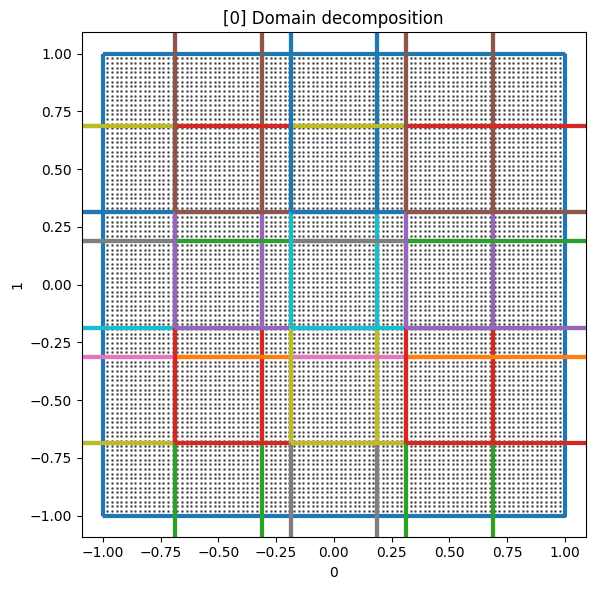

[INFO] 2024-12-12 00:38:40 - [i: 1000/50000] loss: 0.6430 rate: 123.2 elapsed: 0.00 hr test
[INFO] 2024-12-12 00:38:42 - [i: 2000/50000] loss: 0.5426 rate: 446.4 elapsed: 0.00 hr test
[INFO] 2024-12-12 00:38:45 - [i: 3000/50000] loss: 0.3962 rate: 443.8 elapsed: 0.00 hr test
[INFO] 2024-12-12 00:38:47 - [i: 4000/50000] loss: 0.2835 rate: 444.6 elapsed: 0.00 hr test


In [ ]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.problems import GravityDonut
from fbpinns.decompositions import MultilevelRectangularDecompositionND
from fbpinns.networks import FCN
from fbpinns.schedulers import AllActiveSchedulerND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer

import triangle as tr
import matplotlib.tri as mtri

XMIN, XMAX, YMIN, YMAX = -1, 1, -1, 1

# SQUARE
# A = dict(vertices=np.array(((-1, -1), (1, -1), (1, 1), (-1, 1))))
# T = tr.triangulate(A, f"DFqa{0.0005}")
# xbatch_test_triangles = jnp.vstack([T["vertices"][:,0], T["vertices"][:, 1]]).T

# DONUT
# def circle(N, R):
#     i = np.arange(N)
#     theta = i * 2 * np.pi / N
#     pts = np.stack([np.cos(theta), np.sin(theta)], axis=1) * R
#     seg = np.stack([i, i + 1], axis=1) % N
#     return pts, seg

# pts0, seg0 = circle(60, 1.0)
# pts1, seg1 = circle(30, 0.5)
# pts = np.vstack([pts0, pts1])
# seg = np.vstack([seg0, seg1 + seg0.shape[0]])
# A = dict(vertices=pts, segments=seg, holes=[[0, 0]])
# T = tr.triangulate(A, "Fa0.0005") #note that the origin uses 'qpa0.05' here
# tri = mtri.Triangulation(T["vertices"][:,0], T["vertices"][:, 1], triangles=T["triangles"])
# xbatch_test_triangles = np.vstack([T["vertices"][:,0], T["vertices"][:, 1]]).T

w = 2.75
#EXPERIMENT1 --- WITH 2,128,128,1
# subdomain_xss = [[np.array([0.]),np.array([0.])]]
# subdomain_wss = [[np.array([2.]),np.array([2.])]]

#EXPERIMENT2 --- WITH 2,12,12,1
subdomain_xss = [[np.array([0.0]),np.array([0.0])]] + [[np.linspace(-1,1,n_),np.linspace(-1,1,n_)] for n_ in (5,)]
subdomain_wss = [[np.array([2.]),np.array([2.])]] + [get_subdomain_ws(subdomain_xss[1], w)]

#EXPERIMENT3 --- WITH 2,12,12,1
# subdomain_xss = [[np.array([0.0]),np.array([0.0])]] + [[np.linspace(-1,1,n_),np.linspace(-1,1,n_)] for n_ in (5,)] + [[np.linspace(-1,1,n_),np.linspace(-1,1,n_)] for n_ in (10,)]
# subdomain_wss = [[np.array([2.]),np.array([2.])]] + [get_subdomain_ws(subdomain_xss[1], w)] + [get_subdomain_ws(subdomain_xss[2], w)]

# subdomain_xss =\
#     [[np.array([ 0.0]), np.array([ 0.0])]]+\
#     [[np.array([ 0.3]), np.array([ 0.7])]]+\
#     [[np.array([-0.7]), np.array([ 0.3])]]+\
#     [[np.array([-0.3]), np.array([-0.7])]]+\
#     [[np.array([-0.3]), np.array([ 0.7])]]+\
#     [[np.array([ 0.7]), np.array([ 0.3])]]+\
#     [[np.array([ 0.3]), np.array([-0.7])]]+\
#     [[np.array([-0.7]), np.array([-0.3])]]
# subdomain_wss =\
#     [[np.array([ 2.0]), np.array([ 2.0])]]+\
#     [[np.array([ 1.0]), np.array([ 1.0])]]+\
#     [[np.array([ 1.0]), np.array([ 1.0])]]+\
#     [[np.array([ 1.0]), np.array([ 1.0])]]+\
#     [[np.array([ 1.0]), np.array([ 1.0])]]+\
#     [[np.array([ 1.0]), np.array([ 1.0])]]+\
#     [[np.array([ 1.0]), np.array([ 1.0])]]+\
#     [[np.array([ 1.0]), np.array([ 1.0])]]


c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([-1.,-1.]),
        xmax=np.array([1.,1.])
        ),
    problem=GravityDonut,
    problem_init_kwargs = dict(sd=0.1),
    decomposition=MultilevelRectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xss=subdomain_xss,
        subdomain_wss=subdomain_wss,
        unnorm=(0.,3.),
    ),
    network=FCN,
    network_init_kwargs = dict(
        layer_sizes = (2, 12, 12, 1),
    ),
    optimiser_kwargs=dict(learning_rate=5e-4),
    scheduler = AllActiveSchedulerND,
    ns=((100,100),),
    n_test=(100,100),
    n_steps=50000,
    clear_output=True,
)

run = FBPINNTrainer(c)
all_params = run.train()